# Assessing SMEs' GDPR-compliance Through Privacy Policies: A Machine Learning Approach 
The goal of this research is to explore--using natural language processing and machine learning techniques--how organisations differ in their approach towards GDPR-compliance. We intend to do this by assessing privacy policies on their *focus* (rather than completeness) of the GDPR user rights and explore whether there is a correlation with the corresponding organisation's meta-data (e.g., country, service, data-driven). This will give us insight in organisations' interpretation of the GDPR (e.g., stressing a specific part) and factors (e.g., company size) that contribute to this particular interpretation.


#### Approach
read data -> stratified split -> preprocessing -> vectorizing -> random upsampling of training data -> train classification model -> save model and vectorizer -> classify collected datasets from Orbis Europe

---
## DATASET ##
This manually labeled set comprises 250 individual policies, containing over 18,300 natural sentences. For legal reasons, we have anonymized the data set, e.g. we have scrambled all num- bers and substituted names, email addresses, companies and URLs with generic replacements (e.g. ‘company 42645’). <br>
Source: __On GDPR Compliance of Companies’ Privacy Policies__ _by Müller et al._

The five GDPR requirements chosen to evaluate privacy policy compliance:

|No.|	Category|Required content in privacy policy|
|:---:|:---|:---|
|1| DPO | Contact details for the data protection officer or equivalent |
|2| Purpose | Disclosure of the purpose for which personal data is or is not used for |
|3| Acquired data | Disclosure that personal data is or is not collected, and/or which data is collected |
|4| Data sharing | Disclosure if 3rd parties can or cannot access a user’s personal data |
|5| Rights | Disclosure of the user’s right to rectify or erase personal data |

## Import labeled PPs (18.397 sentence snippets)

In [4]:
import pandas

# Let's load the training data from a csv file
dataset = pandas.read_csv('data/PP/GDPR.csv', sep='\t', encoding='utf-8')
dataset

,Text,DPO,Purpose,Acquired data,Data sharing,Rights
0,this is a privacy statement disclosing our inf...,0,0,0,0,0
1,"any other information that we gather, in pursu...",0,0,0,0,0
2,in such circumstances we will continue to send...,0,0,0,0,0
3,the information is not accessible to the publi...,0,0,0,1,0
4,company_32782 ltd will use your personal data ...,0,1,0,0,0
...,...,...,...,...,...,...
18392,you agree that we have the right to share your...,0,0,0,1,0
18393,"in some cases, we may need to share your perso...",0,0,0,1,0
18394,the site includes an online tool which you can...,0,0,0,0,0
18395,that information is provided directly to the t...,0,0,0,0,0


#### Explore balance of dataset
Source: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

Text(0.5, 0, 'GDPR Assessment Criteria')

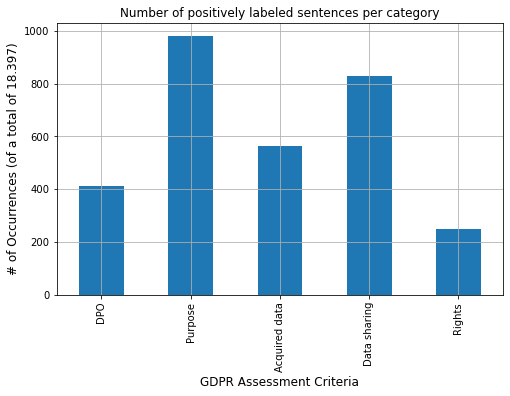

In [5]:
import matplotlib.pyplot as plt

categ = list(dataset.columns)[1:] # select all except 'text' column

counts = []
for column in categ:
#     print(dataset[column].value_counts())
    tmp_count = dataset[column].value_counts()
    # make a list of tuples that contain column name and number of pos labeled sentences     
    counts.append((column, tmp_count[1]))

df_stats = pandas.DataFrame(counts, columns=['GDPR_criteria', 'number_of_pos_sen'])

df_stats.plot(x='GDPR_criteria', y='number_of_pos_sen', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of positively labeled sentences per category")
plt.ylabel('# of Occurrences (of a total of 18.397)', fontsize=12)
plt.xlabel('GDPR Assessment Criteria', fontsize=12)

#### What is the number of multi-labeled sentences?
Source: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

C:\Users\aaberkan\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, '# of GDPR criteria')

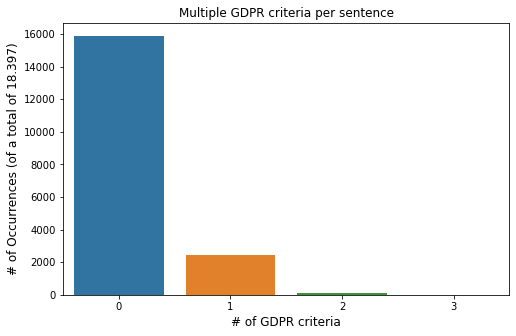

In [6]:
import seaborn as sns
rowsums = dataset.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple GDPR criteria per sentence")
plt.ylabel('# of Occurrences (of a total of 18.397)', fontsize=12)
plt.xlabel('# of GDPR criteria', fontsize=12)

- The vast majority of the sentences is not labeled at all (almost 16.000)

#### Class imbalance, possible solutions:
- oversampling minority class
    - Resample function from scikit-learn packaged: randomly duplicate examples in the minority class.
    - generating synthetic samples using SMOTE functionality in Imblearn package
- undersampling majority class

##### Oversampling should be done on the training set only:
In class imbalance settings, artificially balancing the test/validation set does not make any sense: these sets must remain realistic, i.e. you want to test your classifier performance in the real world setting, where, say, the negative class will include the 99% of the samples, in order to see how well your model will do in predicting the 1% positive class of interest without too many false positives. Artificially inflating the minority class or reducing the majority one will lead to performance metrics that are unrealistic, bearing no real relation to the real world problem you are trying to solve.

Max Kuhn, creator of the caret R package and co-author of the (highly recommended) Applied Predictive Modelling textbook, in Chapter 11: Subsampling For Class Imbalances of the caret ebook:

__You would never want to artificially balance the test set; its class frequencies should be in-line with what one would see “in the wild”.__

Re-balancing makes sense only in the training set, so as to prevent the classifier from simply and naively classifying all instances as negative for a perceived accuracy of 99%.

Hence, you can rest assured that in the setting you describe the rebalancing takes action only for the training set/folds._

sources: 
- https://imbalanced-learn.org/stable/over_sampling.html
- https://stackoverflow.com/questions/48805063/balance-classes-in-cross-validation/48810493#48810493


#### Oversampling

In [7]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
      
def oversample_data(x, y):    
    oversample = RandomOverSampler(sampling_strategy='minority', random_state = 42)
    x_over, y_over = oversample.fit_resample(x, y)
    return x_over, y_over

# print(Counter(y))

#### Preprocessing

In [104]:
from nltk.stem import PorterStemmer
# from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

def preprocessing(pps):
#     tokenizer = nlp.tokenizer
    # tokenize sentences
    tokenized_sent = [sent.split() for sent in pps]
    
    # remove punctuation
    tokenized_sent = [[re.sub('[,’\'\.!?&“”():*_;"]', '', y) for y in x] for x in tokenized_sent]
    
    # remove words with numbers in them
    tokenized_sent = [[y for y in x if not any(c.isdigit() for c in y)] for x in tokenized_sent]
    
    # remove stopwords   
    tokenized_sent_clean = tokenized_sent
#     tokenized_sent_clean = [[y for y in x if y not in stopwords.words('english')] for x in tokenized_sent]
    
    # from nltk.stem import PorterStemmer
    porter = PorterStemmer()
    tokenized_sent_clean = [[porter.stem(y) for y in x] for x in tokenized_sent_clean]
    
#     lemmatizer = WordNetLemmatizer()
#     tokenized_sent_clean = [[lemmatizer.lemmatize(y) for y in x] for x in tokenized_sent_clean]

    
    detokenized_pps = []
    for i in range(len(tokenized_sent_clean)):
        t = ' '.join(tokenized_sent_clean[i])
        detokenized_pps.append(t) 
    
    return detokenized_pps

In [9]:
print("Before preprocessing: ")
print(dataset['Text'].to_list()[0:3])
print()
print("Post preprocessing: ")
print(preprocessing(dataset['Text'].to_list()[:3]))

Before preprocessing: 
['this is a privacy statement disclosing our information gathering, use and dissemination practices for the company_04614 web site.', 'any other information that we gather, in pursuance of the unpaid fee, including    information that is shared by you with us.', 'in such circumstances we will continue to send you service related communications which are non-marketing where necessary.']

Post preprocessing: 
['thi is a privaci statement disclos our inform gather use and dissemin practic for the web site', 'ani other inform that we gather in pursuanc of the unpaid fee includ inform that is share by you with us', 'in such circumst we will continu to send you servic relat commun which are non-market where necessari']


## Feature engineering

#### TF-IDF
<img src="img/tfidfformula.png">


#### TF-IDF Vectorizer
Convert a collection of raw documents to a matrix of TF-IDF features.
Equivalent to CountVectorizer followed by TfidfTransformer.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

- fit (on training set): performs training (using training set)
- transform (on test set): changes the data in the pipeline in order to pass it on
- fit transform: both

## Train model - Classification: Logistic Regression

For classification tasks, Logistic regression models the probabability of an event occurring (e.g., "DPO", "Purpose") depending on the values of the independent variables, which are categorical (in our case even binary: "DPO" is 1 or 0).

We know that z is the weighted sum of the evidence for the class (probability of the class occurring).<br>


\begin{align}
z = c_0+c_1*𝑥_1+c_2*𝑥_2+...+c_𝑛*𝑥_𝑛
\end{align}

The larger the weight the greater impact the given feature has on the final decision:<br>
- large positive values indicate a positive impact (for the event to occur)
- large negative values indicate a negative impact (for the event not to occur)

Z value is between -∞ and +∞. 
Therefore we apply the sigmoid (or logistic function) to this value to obtain prob. values between 0 and 1.
The final probability scores let the model predict the label. If the prob of "Red" is higher than all other labels, the prediction will be "Red".

More info: https://machinelearningmastery.com/logistic-regression-for-machine-learning/

### Optimize parameters
#### TFIDF
___max_df___ float in range [0.0, 1.0] or int, default=1.0, is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:
- max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
- max_df = 25 means "ignore terms that appear in more than 25 documents".
The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

___min_df___ float in range [0.0, 1.0] or int, default=1, is used for removing terms that appear too infrequently. For example:
- min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
- min_df = 5 means "ignore terms that appear in less than 5 documents".
The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.

__ngram_range___ tuple (min_n, max_n), default=(1, 1)
- The lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted.

___max_features___ int, default=None
- If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
- https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

#### Logistic Regression
___max_iter___ int, default=100
- Maximum number of iterations taken for the solvers to converge.

#### Split train and test set (using stratified split) 
- Split dataset into training, 10% (= 16557), and test set (1840)

Because we have multiple labels (5), we need to conduct the train_test_split an equal amount of time to maintain the stratify functionality for each and every label.

Info about stratified split in classification problems: https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/#:~:text=Stratified%20Train%2DTest%20Splits,-One%20final%20consideration&text=As%20such%2C%20it%20is%20desirable,a%20stratified%20train%2Dtest%20split.

In [10]:
from sklearn.model_selection import train_test_split

x_train0, x_test0, train_dpo, test_dpo = train_test_split(dataset['Text'], dataset['DPO'], test_size=.1, 
                                                    random_state=42, stratify=dataset['DPO'])

x_train1, x_test1, train_purpose, test_purpose = train_test_split(dataset['Text'], dataset['Purpose'], test_size=.1, 
                                                    random_state=42, stratify=dataset['Purpose'])

x_train2, x_test2, train_acquired_data, test_acquired_data = train_test_split(dataset['Text'], dataset['Acquired data'], test_size=.1, 
                                                    random_state=42, stratify=dataset['Acquired data'])

x_train3, x_test3, train_data_sharing, test_data_sharing = train_test_split(dataset['Text'], dataset['Data sharing'], test_size=.1, 
                                                    random_state=42, stratify=dataset['Data sharing'])

x_train4, x_test4, train_rights, test_rights = train_test_split(dataset['Text'], dataset['Rights'], test_size=.1, 
                                                    random_state=42, stratify=dataset['Rights'])


train_test = [train_dpo, test_dpo, train_purpose, test_purpose, train_acquired_data, 
              test_acquired_data, train_data_sharing, test_data_sharing, train_rights, test_rights]

train_test_text = [x_train0, x_test0, x_train1, x_test1, x_train2, 
              x_test2, x_train3, x_test3, x_train4, x_test4]

train_data = [element for i, element in enumerate(train_test) if i in [0, 2, 4, 6, 8]]
test_data = [element for i, element in enumerate(train_test) if i in [1, 3, 5, 7, 9]]

train_data_text = [element for i, element in enumerate(train_test_text) if i in [0, 2, 4, 6, 8]]
test_data_text = [element for i, element in enumerate(train_test_text) if i in [1, 3, 5, 7, 9]]


# if x_train5 == x_train2: 
#     print("same")

# train, test = train_test_split(dataset, test_size=0.1, random_state=42)

# train_text = preprocessing(train['Text'].to_list())
# test_text = preprocessing(test['Text'].to_list())

# train_dpo = train['DPO'].to_list()
# test_dpo = test['DPO'].to_list()

# train_purpose = train['Purpose'].to_list()
# test_purpose = test['Purpose'].to_list()

# train_acquired_data = train['Acquired data'].to_list()
# test_acquired_data = test['Acquired data'].to_list()

# train_data_sharing = train['Data sharing'].to_list()
# test_data_sharing = test['Data sharing'].to_list()

# train_rights = train['Rights'].to_list()
# test_rights = test['Rights'].to_list()

# train_test = [train_dpo, test_dpo, train_purpose, test_purpose, train_acquired_data, 
#               test_acquired_data, train_data_sharing, test_data_sharing, train_rights, test_rights]


# test_data = [element for i, element in enumerate(train_test) if i in [1, 3, 5, 7, 9]]
# train_data = [element for i, element in enumerate(train_test) if i in [0, 2, 4, 6, 8]]

# len(train_test)

#### Class distribution after stratified split

In [11]:
import collections 
# print((collections.Counter(train_data[0])))
# print((collections.Counter(test_dpo)))

for idx, ct in enumerate(categ):
    print(ct)
    
    print((collections.Counter(train_data[idx])))
    print((collections.Counter(test_data[idx])))


# frequency_calculated = ({'DPO training (1)':1, 'DPO 1':3, 'C':1, 'D':2, 'E':1, 'F':3, 'G':2})
# plt.bar(frequency_calculated.keys(), frequency_calculated.values())

DPO
Counter({0: 16184, 1: 373})
Counter({0: 1799, 1: 41})
Purpose
Counter({0: 15675, 1: 882})
Counter({0: 1742, 1: 98})
Acquired data
Counter({0: 16049, 1: 508})
Counter({0: 1783, 1: 57})
Data sharing
Counter({0: 15810, 1: 747})
Counter({0: 1757, 1: 83})
Rights
Counter({0: 16331, 1: 226})
Counter({0: 1815, 1: 25})


### Optimize parameters
We optimize paramaters (ngrams) on the training set only to avoid overfitting.

#### Cross-validation
GridSearchCV:
- best_score_: Mean cross-validated score of the best_estimator
- cv: default 5-fold cross validation
    - For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, __StratifiedKFold__ is used. In all other cases, KFold is used. (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- scoring: precision, etc. (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
    - scoring = None: score function of (LR) classifier will be used 
        - score(X, y, sample_weight=None): Return the mean __accuracy__ on the given test data and labels.

#### Oversampling & Cross-validation
If cross-validation is done on already upsampled data, some of the duplicates due to upsampling will end up both to the training and the validation splits (CV folds); the result being that the algorithm is validated with some samples that have already been seen during training, which invalidates the very fundamental requirement of a validation set (fold) and it is actually the very definition of __data leakage__:

_"You would never want to artificially balance the test set; its class frequencies should be in-line with what one would see 'in the wild'."_ - Max Kuhn in Applied Predictive Modelling (Ch. 11).

sources:
- https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://datascience.stackexchange.com/a/82093

In [75]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from imblearn.over_sampling import RandomOverSampler
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline

__Option 1: CV without oversampling__

If we select "precision" for scoring metric, we get, except for the first label (i.e. DPO) the following warning message:
_UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples._

In [98]:
# 'UR_explicitly_mentioned' weggelaten
# categories = ['Purpose']
# prep_dataset = preprocessing(pps = dataset['Text'].to_list())

for i, category in enumerate(categ):
    tfidf_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('lr', LogisticRegression()),
    ])

    # increase processing time in a combinatorial way
    parameters = {
#         'tfidf__min_df': (.05, .1, .15, .2), #best solution: (.75)
#         'tfidf__max_df': (0.75, .85), #best solution: (1.)
#         'tfidf__max_features': (None, 5000, 10000, 50000),
        'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)), #best solution: (1,2)
#         'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)), #best solution: (1,2)
    }

    x_train = preprocessing(train_data_text[i])
    y_train = train_data[i]
    
#     sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.25, random_state = 42)
    # shuffle data once at the start, then split (test sets do not overlap ict shufflesplit)
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    grid_search = GridSearchCV(tfidf_pipeline, parameters, cv = skf, scoring = "precision")

    print("Performing grid search for label: {}".format(category))
    print("tf-idf pipeline:", [name for name, _ in tfidf_pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(x_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print()

Performing grid search for label: DPO
tf-idf pipeline: ['tfidf', 'lr']
parameters:
{'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2))}
done in 12.092s

Best score: 0.805
Best parameters set:
	tfidf__ngram_range: (1, 2)

Performing grid search for label: Purpose
tf-idf pipeline: ['tfidf', 'lr']
parameters:
{'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2))}
done in 12.100s

Best score: 0.819
Best parameters set:
	tfidf__ngram_range: (1, 2)

Performing grid search for label: Acquired data
tf-idf pipeline: ['tfidf', 'lr']
parameters:
{'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2))}
done in 12.452s

Best score: 0.909
Best parameters set:
	tfidf__ngram_range: (2, 2)

Performing grid search for label: Data sharing
tf-idf pipeline: ['tfidf', 'lr']
parameters:
{'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2))}
done in 12.468s

Best score: 0.830
Best parameters set:
	tfidf__ngram_range: (2, 2)

Performing grid search for label: Rights
tf-idf pipeline: ['tfidf', 'lr']
parameters:
{'tfidf__ngram_range': 

__Option 2: with oversampling__

Source: https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html

In [85]:
for i, category in enumerate(categ):
    tfidf_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('lr', LogisticRegression()),
    ])

    # increase processing time in a combinatorial way
    parameters = {
#         'tfidf__min_df': (.05, .1, .15, .2), #best solution: (.75)
#         'tfidf__max_df': (0.75, .85), #best solution: (1.)
#         'tfidf__max_features': (None, 5000, 10000, 50000),
        'logisticregression__max_iter': [200],
        'tfidfvectorizer__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)), #best solution: (1,2)
    }

    x_train = preprocessing(train_data_text[i])
    y_train = train_data[i]
    
#     sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.25, random_state = 42)
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)


    imba_pipeline = make_pipeline(TfidfVectorizer(), RandomOverSampler(sampling_strategy='minority', random_state = 42), 
                                  LogisticRegression())

    grid_search = GridSearchCV(imba_pipeline, parameters, cv = skf, scoring = "precision", 
                               return_train_score=True)

    print("Performing grid search for label: {}".format(category))
#     print("tf-idf pipeline:", [name for name, _ in tfidf_pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(x_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print()


Performing grid search for label: DPO
parameters:
{'logisticregression__max_iter': [200],
 'tfidfvectorizer__ngram_range': ((1, 1),
                                  (1, 2),
                                  (1, 3),
                                  (2, 2),
                                  (2, 3),
                                  (3, 3))}
done in 74.526s

Best score: 0.497
Best parameters set:
	logisticregression__max_iter: 200
	tfidfvectorizer__ngram_range: (3, 3)

Performing grid search for label: Purpose
parameters:
{'logisticregression__max_iter': [200],
 'tfidfvectorizer__ngram_range': ((1, 1),
                                  (1, 2),
                                  (1, 3),
                                  (2, 2),
                                  (2, 3),
                                  (3, 3))}
done in 73.079s

Best score: 0.507
Best parameters set:
	logisticregression__max_iter: 200
	tfidfvectorizer__ngram_range: (3, 3)

Performing grid search for label: Acquired data
pa

### Results parameter optimization
Using different metrics for 'scoring', e.g.: 'accuracy'. 

|Label|Approach|Accuracy|Precision|Recall|
|:---:|:---|:---:|:---:|:---:|
|DPO| preprocessing + ngram(1, 2) | 0.982 | - | - |
|* DPO| preprocessing + ngram(3, 3) | - | 0.848 | - |
|** DPO| preprocessing + ngram(1, 2) | - | 0.805 | - |
|DPO| preprocessing + ngram(1, 1) | - | - | 0.325 |
|DPO| preprocessing + ngram(3, 3) + oversampling | 0.977 | - | - |
|DPO| preprocessing + ngram(3, 3) + oversampling | - | 0.497 | - |
|DPO| preprocessing + ngram(1, 1) + oversampling | - | - | 0.863 |
|Purpose| preprocessing + ngram(1, 3) | 0.956 | - | - |
|* Purpose| preprocessing + ngram(3, 3) | - | 0.865 | - |
|** Purpose| preprocessing + ngram(1, 2) | - | 0.819 | - |
|Purpose| preprocessing + ngram(1, 2) | - | - | .230 |
|Purpose| preprocessing + ngram(3, 3) + oversampling | 0.948 | - | - |
|Purpose| preprocessing + ngram(3, 3) + oversampling | - | 0.507 | - |
|Purpose| preprocessing + ngram(1, 1) + oversampling | - | - | 0.746 |
|Acquired data| preprocessing + ngram(1, 1) | 0.977 | - | - |
|* Acquired data| preprocessing + ngram(3, 3) | - | 0.927 | - |
|** Acquired data| preprocessing + ngram(2, 2) | - | 0.909 | - |
|Acquired data| preprocessing + ngram(1, 1) | - | - | 0.301 |
|Acquired data| preprocessing + ngram(3, 3) | 0.972 | - | - |
|Acquired data| preprocessing + ngram(3, 3) | - | 0.550 | - |
|Acquired data| preprocessing + ngram(1, 1) | - | - | 0.768 |
|Data sharing| preprocessing + ngram(1, 1) | 0.968 | - | - |
|* Data sharing| preprocessing + ngram(3, 3) | - | 0.853 | - |
|** Data sharing| preprocessing + ngram(2, 2) | - | 0.830 | - |
|Data sharing| preprocessing + ngram(1, 1) | - | - | 0.408 |
|Data sharing| preprocessing + ngram(3, 3) | 0.969 | - | - |
|Data sharing| preprocessing + ngram(3, 3) | - | 0.642 | - |
|Data sharing| preprocessing + ngram(1, 1) | - | - | 0.894 |
|Rights| preprocessing + ngram(1, 1) | 0.991 | - | - |
|* Rights| preprocessing + ngram(1, 2) | - | 0.964 | - |
|Rights| preprocessing + ngram(1, 1) | - | - | 0.367 |
|Rights| preprocessing + ngram(1, 3) + oversampling | 0.990 | - | - |
|Rights| preprocessing + ngram(1, 3) + oversampling | - | 0.601 | - |
|Rights| preprocessing + ngram(1, 1) + oversampling | - | - | 0.920 |

# Predict & Evaluate

Methods to identify the performance of the classification model for different cutoff probabilities, an to plot the corresponding precision and recall

In [66]:
def cutoff_results(y_test, y_prob):
    # Let's create columns with different probability cutoffs 
    thresholds = [float(x)/10 for x in range(10)]
    precision_list = []
    recall_list = []
    accuracy_list = []
    
    for i in thresholds:
        y_pred_o = np.where(y_prob > i, 1, 0)
        precision_list.append(precision_score(y_test, y_pred_o))
        recall_list.append(recall_score(y_test, y_pred_o))
        accuracy_list.append(accuracy_score(y_test, y_pred_o))

    pres_thresh = zip(thresholds, precision_list)
    rec_thresh = zip(thresholds, recall_list)
    return precision_list, recall_list, accuracy_list, thresholds, pres_thresh, rec_thresh


def plot_cutoff(y_test, y_prob, find_intersection):
    precision_list, recall_list, accuracy_list, thresholds, pres_thresh, rec_thresh = cutoff_results(y_test, y_prob)
    intersection_x = arr.array('d', [0.5])
    
    # plotting the points 
    plt.plot(thresholds, precision_list, label = "precision")
    plt.plot(thresholds, recall_list, label = "recall")
#     plt.plot(thresholds, accuracy_list, label = "accuracy")

    if (0.0 not in precision_list): 
        line_1 = LineString(pres_thresh)
        line_2 = LineString(rec_thresh)      
        
        intersection = line_1.intersection(line_2)
        plt.plot(*intersection.xy, 'ro')
        intersection_x, intersection_y = intersection.xy

    plt.legend()

    # naming the x axis
    plt.xlabel('treshold')
    # naming the y axis
    plt.ylabel('performance')

    # giving a title to my graph
    plt.title(category + ' performance plot')

    # function to show the plot
    plt.show()

    return intersection_x

Using optimized parameters

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import pickle
from shapely.geometry import LineString
import array as arr

Label in progress:DPO

Ngram: (1, 2)
[0 1]
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


C:\Users\aaberkan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


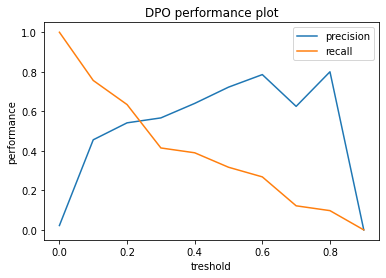


Most important features:
0
contact 4.896669823000577
offic 4.157876800657222
at 4.073012968211403
pleas 3.9799263300630847
email 3.7978030067592314
data protect 3.360369004835531
us at 3.280769933693517
if you 2.870615797884111
protect offic 2.698418205791748
pleas contact 2.592963702778125
...
INTERCEPT:-4.930628193912587
...
other -0.7947122987577346
we may -0.7986658834071166
it -0.8500481874623198
not -0.8584563636378101
provid -0.9231641092236212
cooki -1.0076328059192734
will -1.1023758412436548
servic -1.1242355541569815
we -1.32453200895237
and -1.5557597156852063



Confusion matrix:
[[1794    5]
 [  28   13]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1799
           1       0.72      0.32      0.44        41

    accuracy                           0.98      1840
   macro avg       0.85      0.66      0.72      1840
weighted avg       0.98      0.98      0.98      1840


TFIDF ROC_AUC Score 

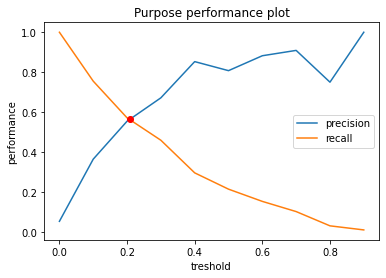


Most important features:
0
to 4.130197594085201
use 4.020221244914912
purpos 3.9622017735053503
use your 3.754008534545305
and 3.6991300671010254
for 3.0160954697321745
follow purpos 2.8734418030606785
you 2.714215000396294
will use 2.6646955372959993
may use 2.661835628160347
...
INTERCEPT:-4.345441464177823
...
to the -1.20778451961072
pleas -1.2261973994441564
if -1.2375399970210437
not -1.2950900748145764
access -1.4012482582307626
right to -1.4248206242416472
how -1.4516453530094446
privaci -1.5069476989093615
right -1.7673362975384674
cooki -2.6808883838220896



Confusion matrix:
[[1737    5]
 [  77   21]]

Classification report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1742
           1       0.81      0.21      0.34        98

    accuracy                           0.96      1840
   macro avg       0.88      0.61      0.66      1840
weighted avg       0.95      0.96      0.94      1840


TFIDF ROC_AUC Score 0.9500

C:\Users\aaberkan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


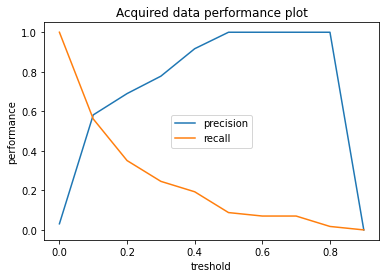


Most important features:
0
email address 4.6383400175067075
such as 4.064004738603886
your name 3.9454041438654164
we collect 3.840231465754071
name address 3.6864090680298958
address and 2.6481090826148805
of birth 2.6353330863650783
address telephon 2.6204226619095294
contact detail 2.586143404232947
phone number 2.514491507108108
...
INTERCEPT:-3.871389224092717
...
your data -0.8316364503744933
thi privaci -0.8661909626561195
we use -0.8680853949614201
the right -0.9469624877209621
you can -0.9952724850432948
how we -0.9953067872438504
your inform -1.0196644528208456
right to -1.0981453645527937
privaci polici -1.1870841862802568
your person -1.7717148849935695



Confusion matrix:
[[1783    0]
 [  52    5]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1783
           1       1.00      0.09      0.16        57

    accuracy                           0.97      1840
   macro avg       0.99      0.54  

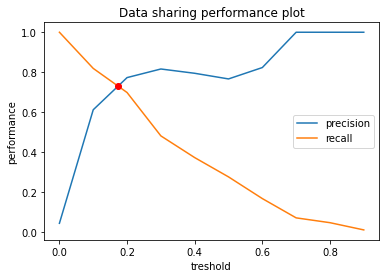


Most important features:
0
third parti 6.869207931945984
share your 5.6519520226450055
inform with 5.405993196470374
disclos your 3.8090779795529253
we may 3.226890655160276
may share 3.0115272433179365
to third 3.0013523841662706
your person 2.975391940927505
share person 2.8610342113495104
will never 2.82127628793255
...
INTERCEPT:-4.020819447068588
...
our websit -0.8885533300535937
right to -0.9045209973573367
the site -0.9060424876551442
you can -0.9268669339675643
the websit -0.9545885435656294
may use -1.0300235956438106
of your -1.0471796026347915
are not -1.0550647799426098
use of -1.2616191815710895
use your -1.8795032045943028



Confusion matrix:
[[1750    7]
 [  60   23]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1757
           1       0.77      0.28      0.41        83

    accuracy                           0.96      1840
   macro avg       0.87      0.64      0.69      1840
weighted 

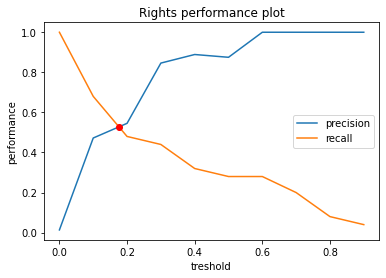


Most important features:
0
correct 5.789178622613907
delet 5.014243195039494
erasur 3.6501930167524446
request 3.438926747905327
eras 3.3020553078341015
right to 3.085473201766321
right 2.9879183754483205
remov 2.986583437703382
inaccur 2.944487462592666
or 2.5087449798379735
...
INTERCEPT:-5.310427203203095
...
with -0.6232295777437652
other -0.624072681075481
polici -0.6673301605282058
cooki -0.7354216024889058
privaci -0.7529670004361468
are -0.7634839523478054
use -0.8122471681071818
servic -0.8159802068905454
collect -0.8572113551507714
websit -0.8801218850385572



Confusion matrix:
[[1814    1]
 [  18    7]]

Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1815
           1       0.88      0.28      0.42        25

    accuracy                           0.99      1840
   macro avg       0.93      0.64      0.71      1840
weighted avg       0.99      0.99      0.99      1840


TFIDF ROC_AUC Score 0.99

In [107]:
# params = [(1,1), (1,2), (1,1), (1,1), (1,1)] # stemming + stopwords + ngrams
# params = [(1,1), (1,1), (1,1), (1,1), (1,1)] # stemming + ngrams
# params = [(1,1), (1,1), (1,1), (1,1), (1,1)] # lemmatizing + ngrams
# params = [(3,3), (3,3), (3,3), (3,3), (1,2)] # stemming + ngrams
params = [(1,2), (1,2), (2,2), (2,2), (1,2)] # stemming + ngrams

for i, category in enumerate(categ):
    print("Label in progress:" + category)
    print()
    
    # initalise the vectorizer 
#     vectorizer = TfidfVectorizer(max_df = .75, min_df = .05, ngram_range = (1,2))
    vectorizer = TfidfVectorizer(ngram_range = params[i])
    print("Ngram:", params[i])

    x_train = preprocessing(train_data_text[i])
    x_test = preprocessing(test_data_text[i])
    
    x_train = vectorizer.fit_transform(x_train)
    x_test = vectorizer.transform(x_test)
    
    y_train = train_data[i]
    y_test = test_data[i]

#     x_train, y_train = oversample_data(x_train, y_train)
    
    # Make an instance of the Model
    # all parameters not specified are set to their defaults
    lr = LogisticRegression(max_iter = 100)

    # Train the model on the data, storing the information learned from the data
    # Model is learning the relationship between digits (x_train) and labels (y_train)
    
    lr.fit(x_train, y_train)
        
    # Save to file in the current working directory
    lr_file = "linreg-" + category + ".pkl"
#     lr_file = "linreg-oversampling-" + category + ".pkl"
    with open(lr_file, 'wb') as file:
        pickle.dump((vectorizer, lr), file)
    
    
    # Let's see what are the possible labels to predict (and in which order they are stored)
    print(lr.classes_)

    # We can get additional information about all the parameters used with LogReg model
    print(lr.get_params())

    y_pred = lr.predict(x_test)
    y_prob = lr.predict_proba(x_test)[:,1]
    
    cutoff_x = plot_cutoff(y_test, y_prob, False)
    
    y_pred_o = [1 if i > cutoff_x[0] else 0 for i in y_prob]
    words = vectorizer.get_feature_names()

    print()
    print("Most important features:")
    for label, coefs, intercept in zip(lr.classes_, lr.coef_, lr.intercept_):
        print(label)
        sort_zipped_list = sorted(zip(words, coefs), key = lambda x: x[1], reverse = True) 
        for t, c in list(sort_zipped_list)[:10]:
            print(t, c)
        print("...")
        print("INTERCEPT:" +str(intercept))
        print("...")
        for t, c in list(sort_zipped_list)[-10:]:
            print(t, c)
        print()
        print()
        
    print()    
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print()
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    print()    
    print("TFIDF ROC_AUC Score", roc_auc_score(y_test, y_prob))
    print()    

    if(cutoff_x[0] != 0.5):
        print("Confusion matrix with cut-off point = ", cutoff_x[0]," :")
        print(confusion_matrix(y_test, y_pred_o))
        print()
        print("Classification reportwith cut-off point = ", cutoff_x[0]," :")
        print(classification_report(y_test, y_pred_o))
    
    print("----------------------------------")
    print()

### Background: performance metrics

### Accuracy ### 
For label X, accuracy is the number of correctly predicted labels divided by all labels<br>

\begin{align}
Accuracy(p) = \frac{correctly\ predicted\ as\ label\ A}{all\ predictions\ made} = \frac{true\ positives\ +\ true\ negatives}{true\ positives\ +\ false\ positives\ +\ true\ negatives\ +\ false\ negatives} \\
\end{align}

true positive = correctly predicted as label A<br>
false positive = incorrectly predicted as label A<br>
true negative = correctly predicted as not label A<br>
false negative = predicted as another label, whereas it is actually label A

- ___Is not very helpful in case of class imbalance (classifying everything to the majority class will result in this case in a good accuracy)___


### Precision ### 
For label X, precision is the number of correctly predicted labels __out of all predicted labels__ (for the actual label X) (What percent of the predicted labels are correct? The focus is on predictions.).<br>

\begin{align}
Precision(p) = \frac{correctly\ predicted\ as\ label\ A}{all\ predictions\ made\ as\ label\ A} = \frac{true\ positives}{true\ positives\ +\ false\ positives} \\
\end{align}

true positive = correctly predicted as label A<br>
false positive = incorrectly predicted as label A<br>


### Recall ### 
For label X, recall is the number of correctly predicted labels (same as above) __out of the number of actual labels A__ (Out of all actual label A's, what percent of them did the model predict correctly? The focus is on actual labels.).<br>
In other words: r = true positives / (true positives + false negatives)

\begin{align}
Recall(r) = \frac{correctly\ predicted\ as\ label\ A}{all\ actual\ items\ with\ label\ A} = \frac{true\ positives}{true\ positives\ +\ false\ negatives} \\
\end{align}

true positive = correctly predicted as label A<br>
false negative = predicted as another label, whereas it is actually label A

### F1 Score ###
Ok so precision and recall measures the performance of a model from two different perspectives.
We can combine the two measures to get a single, balanced score, which is also called __F1 score__.
Obtaining a single score is often easier to compare different models.

\begin{align}
F1 = 2 * \frac{Precision * Recall}{Precision + Recall} \\
\end{align}


### Area Under the Curve (AUC) ###
The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.
_The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes._
- When AUC = 1, then the classifier is able to perfectly distinguish between all the Positive and the Negative class points correctly. 
- If, however, the AUC had been 0, then the classifier would be predicting all Negatives as Positives, and all Positives as Negatives.
- When 0.5<AUC<1, there is a high chance that the classifier will be able to distinguish the positive class values from the negative class values.
- When AUC=0.5, then the classifier is not able to distinguish between Positive and Negative class points. Meaning either the classifier is predicting random class or constant class for all the data points

Source: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

### Classification report ###
- __macro avg__: Calculate precision, recall and f1 metrics for each label, and find their average. This does not take label imbalance into account: f1 scores are averaged (with equal weights)
- __weighted avg__: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters "macro" to account for label imbalance (it can result in an F-score that is not between precision and recall).

### Confusion matrix ###

| |Actual|label|
|---|---|---|
|Predicted| TN | FP |
|label| FN | TP |

## Evaluate

### Performance (Logistic Regression)
|Label|Approach|Precision|Recall|F1|AUC|
|:---:|:---|:---:|:---:|:---:|:---:|
|DPO|stemming + ngram(1,2)|0.85 (0.98)|0.66 (0.98)|0.72 (0.98)|0.981|
|Purpose|stemming + ngram(1,2)|0.88 (0.95)|0.61 (0.96)|0.66 (0.94)|0.950|
|Acquired data|stemming + ngram(2,2)|0.99 (0.97)|0.54 (0.97)|0.57 (0.96)|0.945|
|Data sharing|stemming + ngram(2,2)|0.87 (0.96)|0.64 (0.96)|0.69 (0.96)|0.970|
|Rights|stemming + ngram(1,2)|0.93 (0.99)|0.64 (0.99)|0.71 (0.99)|0.991|


### Most important features 
|DPO|Purpose|Acquired data|Data sharing|Rights|
|:---|:---|:---|:---|:---|
|contact| to | email address | third parti | correct |
|offic| use | such as  | share your | delet |
|at| purpos | your name | inform with | erasur |
|pleas| use your | we collect | disclos your | request |
|email| and | name address | we may | eras |
|data protect| for | address | may whare | right to |
|us at| interest | of birth | to third | right |
|if you| you | address telephon | your person | remov |
|protect offic| contact detail | includ | share person | inaccur |
|pleas contact| phone number | record | will never | or |


----------------------------
### OLD
|Label|Approach|Precision|Recall|F1|AUC|
|:---:|:---|:---:|:---:|:---:|:---:|
|DPO|stemming + stopwords removal + ngram(1,1)|0.81 (0.98)|0.67 (0.97)|0.72 (0.98)|0.973|
|DPO|stemming + ngram(1,1)|0.79 (0.98)|0.68 (0.98)|0.72 (0.98)|0.977|
|DPO|oversampling + stemming + ngram(1,1)|0.67 (0.98)|0.88 (0.96)|0.73 (0.97)|0.980|
|Purpose|stemming + stopwords removal + ngram(1,2)|0.88 (0.95)|0.60 (0.95)|0.65 (0.94)|0.943|
|Purpose|stemming + ngram(1,2)|0.83 (0.94)|0.61 (0.95)|0.66 (0.94)|0.936|
|Purpose|oversampling + stemming + ngram(1,2)|0.65 (0.95)|0.86 (0.90)|0.70 (0.92)|0.934|
|Acquired data|stemming + stopwords removal + ngram(1,1)|0.96 (0.98)|0.63 (0.98)|0.70 (0.97)|0.931|
|Acquired data|stemming + ngram(1,1)|0.93 (0.97)|0.63 (0.98)|0.70 (0.97)|0.942|
|Acquired data|oversampling + stemming + ngram(1,1)|0.64 (0.97)|0.79 (0.94)|0.69 (0.95)|0.930|
|Data sharing|stemming + stopwords removal + ngram(1,1)|0.87 (0.96)|0.67 (0.97)|0.73 (0.96)|0.970|
|Data sharing|stemming + ngram(1,1)|0.87 (0.96)|0.70 (0.97)|0.75 (0.96)|0.973|
|Data sharing|oversampling + stemming + ngram(1,1)|0.75 (0.97)|0.93 (0.96)|0.81 (0.96)|0.975|
|Rights|stemming + stopwords removal + ngram(1,1)|0.95 (0.99)|0.68 (0.99)|0.75 (0.99)|0.992|
|Rights|stemming + ngram(1,1)|0.95 (0.99)|0.70 (0.99)|0.78 (0.99)|0.993|
|Rights|oversampling + stemming + ngram(1,1)|0.77 (0.99)|0.95 (0.99)|0.84 (0.99)|0.996|

# Analysis

|DPO (1799N, 41P)| Predicted N | Predicted P | | Predicted N | Predicted P |
|:---:|:---:|:---:|:---:|:---:|:---:|
| Actual N | 1794 | 5 | -> | 1752 | 47 |
| Actual P | 28 | 13 | -> | 8 | 33 |

- precision drops after oversampling
    - this is due the increase of false positives
- recall increases after oversampling
    - due to the decrease of false negatives 
    
#### Adjust cut-off point
Introducing special thresholds only affects in the proportion of false positives/false negatives, and thus in precision/recall tradeoff, but it is not the parameter of the LR model. 

Source: 
- https://stackoverflow.com/questions/53846943/sklearn-logistic-regression-adjust-cutoff-point
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
- https://www.kaggle.com/dstuerzer/optimized-logistic-regression
- https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
- https://github.com/aldwin160/python/blob/master/finding%20the%20intersection%20of%20two%20curves.py (intersection of 2 curves using Shapely)

## Focus on Recall or Precision?
- Precision: appropriate when minimizing false positives is the focus
- Recall: appropriate when minimizing false negatives is the focus

We are focusing on precision because we aim to minimize false positives. We consider false positives to be a bigger problem than false negatives, because a false positive will give us the incorrect impression that a privacy policy covers a particuler GDPR-requirement (e.g. mentioning DPO).

Source: https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/


#### How many sentences do we need to identify one positive sentence (without oversampling)?
Let us use a precision threshold of 90%: __how many sentences do we need to identify a true positive sentence with 90% precision?__

_Example:_

|DPO (1799N, 41P)| Predicted N | Predicted P |
|:---:|:---:|:---:|
| Actual N | 1794 | 5 |
| Actual P | 28 | 13 |


\begin{align}
P(pos\ sen\ is\ true\ pos) = \frac{13}{5 + 13} = 0.72 \\
P(pos\ sen\ is\ false\ pos) = 1 - 0.6 = 0.28 \\
P(2\ pos\ sen\ are\ false\ pos) = 0.28^2 \approx 0.078 \\
P(one\ in\ 1\ pos\ sen\ is\ true\ pos) \approx 1 - 0.078 = 0.92 
\end{align}

|Label| Precision | Threshold (> 0.90%) | Threshold (> 0.80%) |
|:---|:---|:---|:---|
| DPO | 13 / (5 + 13) = 0.72 | \begin{align} P(one\ in\ 2\ pos\ sen\ is\ true\ pos) \approx 0.92 \end{align}| \begin{align} P(one\ in\ 2\ pos\ sen\ is\ true\ pos) \approx 0.92 \end{align}|
| Purpose | 21 / (5 + 21) = 0.81 | \begin{align} P(one\ in\ 2\ pos\ sen\ is\ true\ pos) \approx 0.96 \end{align} |  \begin{align} P(one\ in\ 2\ pos\ sen\ is\ true\ pos) \approx 0.96 \end{align}|
| Acquired Data | 5 / (0 + 5) = 1 | \begin{align} P(pos\ sen\ is\ true\ pos) \approx 1 \end{align} | \begin{align} P(pos\ sen\ is\ true\ pos) \approx 0.88 \end{align}|
| Data Sharing | 23 / (7 + 23) = 0.77 | \begin{align} P(one\ in\ 2\ pos\ sen\ is\ true\ pos) \approx 0.95 \end{align} | \begin{align} P(one\ in\ 2\ pos\ sen\ is\ true\ pos) \approx 0.95 \end{align}|
| Rights | 7 / (1 + 7) = 0.86 | \begin{align} P(one\ in\ 2\ pos\ sen\ is\ true\ pos) \approx 0.98 \end{align} | \begin{align} P(pos\ sen\ is\ true\ pos) \approx 0.91 \end{align}|


#### Cut-off 
https://medium.com/swlh/determining-a-cut-off-or-threshold-when-working-with-a-binary-dependent-target-variable-7c2342cf2a7c

## Predict collected dataset of scraped SME policies

In [119]:
# thresholds
# sen_thresh = [2, 2, 1, 2, 2]
#without
sen_thresh = [1, 1, 1, 1, 1]

In [120]:
# dataset_sme = pandas.read_csv('data/SME/SME-GDPR-test.csv', sep='\t', encoding='utf-8')
# dataset_sme

# import necessary libraries
import pandas as pd
import os
import glob
import numpy
  
scores_sme = numpy.zeros((5, 1000))    
    
# use glob to get all the csv files 
# in the folder
path = 'data\SME'
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
print(len(csv_files))  
# loop over the list of csv files
for j, f in enumerate(csv_files):
    print("This is file: ", j, "of ", len(csv_files))
    
    df_sme = pandas.read_csv(f, sep='\t', encoding='utf-8')
    test_text, test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat = get_data(df_sme)
    sme_test_data = [test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat]

    for i, category in enumerate(categ):
        
         # Load from file to check if everything is ok
#         filen = "linreg-oversampling-" + category + ".pkl"      
        filen = "linreg-" + category + ".pkl"      
        with open(filen, 'rb') as file:
            vectorizer, lr = pickle.load(file)

#         print("* Label = ", category)

        x_test = preprocessing(test_text)
        x_test = vectorizer.transform(x_test)

        y_test = sme_test_data[i]
        y_pred = lr.predict(x_test)
        
#         if (category == "DPO"):
#             print("# 1s: ", list(y_pred).count(1))
#             print("threshold: ", sen_thresh[i])
        
        if list(y_pred).count(1) >= sen_thresh[i]:
            scores_sme[i][j] = 1
#             if (category == "DPO"):
#                 print("#BINGO")


#         print("")
#         print("")
#         print("")

1000
This is file:  0 of  1000
This is file:  1 of  1000
This is file:  2 of  1000
This is file:  3 of  1000
This is file:  4 of  1000
This is file:  5 of  1000
This is file:  6 of  1000
This is file:  7 of  1000
This is file:  8 of  1000
This is file:  9 of  1000
This is file:  10 of  1000
This is file:  11 of  1000
This is file:  12 of  1000
This is file:  13 of  1000
This is file:  14 of  1000
This is file:  15 of  1000
This is file:  16 of  1000
This is file:  17 of  1000
This is file:  18 of  1000
This is file:  19 of  1000
This is file:  20 of  1000
This is file:  21 of  1000
This is file:  22 of  1000
This is file:  23 of  1000
This is file:  24 of  1000
This is file:  25 of  1000
This is file:  26 of  1000
This is file:  27 of  1000
This is file:  28 of  1000
This is file:  29 of  1000
This is file:  30 of  1000
This is file:  31 of  1000
This is file:  32 of  1000
This is file:  33 of  1000
This is file:  34 of  1000
This is file:  35 of  1000
This is file:  36 of  1000
This i

This is file:  297 of  1000
This is file:  298 of  1000
This is file:  299 of  1000
This is file:  300 of  1000
This is file:  301 of  1000
This is file:  302 of  1000
This is file:  303 of  1000
This is file:  304 of  1000
This is file:  305 of  1000
This is file:  306 of  1000
This is file:  307 of  1000
This is file:  308 of  1000
This is file:  309 of  1000
This is file:  310 of  1000
This is file:  311 of  1000
This is file:  312 of  1000
This is file:  313 of  1000
This is file:  314 of  1000
This is file:  315 of  1000
This is file:  316 of  1000
This is file:  317 of  1000
This is file:  318 of  1000
This is file:  319 of  1000
This is file:  320 of  1000
This is file:  321 of  1000
This is file:  322 of  1000
This is file:  323 of  1000
This is file:  324 of  1000
This is file:  325 of  1000
This is file:  326 of  1000
This is file:  327 of  1000
This is file:  328 of  1000
This is file:  329 of  1000
This is file:  330 of  1000
This is file:  331 of  1000
This is file:  332 o

This is file:  591 of  1000
This is file:  592 of  1000
This is file:  593 of  1000
This is file:  594 of  1000
This is file:  595 of  1000
This is file:  596 of  1000
This is file:  597 of  1000
This is file:  598 of  1000
This is file:  599 of  1000
This is file:  600 of  1000
This is file:  601 of  1000
This is file:  602 of  1000
This is file:  603 of  1000
This is file:  604 of  1000
This is file:  605 of  1000
This is file:  606 of  1000
This is file:  607 of  1000
This is file:  608 of  1000
This is file:  609 of  1000
This is file:  610 of  1000
This is file:  611 of  1000
This is file:  612 of  1000
This is file:  613 of  1000
This is file:  614 of  1000
This is file:  615 of  1000
This is file:  616 of  1000
This is file:  617 of  1000
This is file:  618 of  1000
This is file:  619 of  1000
This is file:  620 of  1000
This is file:  621 of  1000
This is file:  622 of  1000
This is file:  623 of  1000
This is file:  624 of  1000
This is file:  625 of  1000
This is file:  626 o

This is file:  884 of  1000
This is file:  885 of  1000
This is file:  886 of  1000
This is file:  887 of  1000
This is file:  888 of  1000
This is file:  889 of  1000
This is file:  890 of  1000
This is file:  891 of  1000
This is file:  892 of  1000
This is file:  893 of  1000
This is file:  894 of  1000
This is file:  895 of  1000
This is file:  896 of  1000
This is file:  897 of  1000
This is file:  898 of  1000
This is file:  899 of  1000
This is file:  900 of  1000
This is file:  901 of  1000
This is file:  902 of  1000
This is file:  903 of  1000
This is file:  904 of  1000
This is file:  905 of  1000
This is file:  906 of  1000
This is file:  907 of  1000
This is file:  908 of  1000
This is file:  909 of  1000
This is file:  910 of  1000
This is file:  911 of  1000
This is file:  912 of  1000
This is file:  913 of  1000
This is file:  914 of  1000
This is file:  915 of  1000
This is file:  916 of  1000
This is file:  917 of  1000
This is file:  918 of  1000
This is file:  919 o

In [115]:
list(scores_sme[0]).count(1)/len(list(scores_sme[0]))

0.143

## Predict collected dataset of LE policies

In [121]:
# dataset_sme = pandas.read_csv('data/SME/SME-GDPR-test.csv', sep='\t', encoding='utf-8')
# dataset_sme

# import necessary libraries
import pandas as pd
import os
import glob
import numpy
  
scores_le = numpy.zeros((5, 1000))    
    
# use glob to get all the csv files 
# in the folder
path = 'data\LE'
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
# loop over the list of csv files
for j, f in enumerate(csv_files):
    print("This is file: ", j, "of ", len(csv_files))
    
    df_le = pandas.read_csv(f, sep='\t', encoding='utf-8')
    test_text, test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat = get_data(df_le)
    le_test_data = [test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat]

    for i, category in enumerate(categ):
        
         # Load from file to check if everything is ok
        filen = "linreg-oversampling-" + category + ".pkl"      
        with open(filen, 'rb') as file:
            vectorizer, lr = pickle.load(file)

#         print("* Label = ", category)

        x_test = preprocessing(test_text)
        x_test = vectorizer.transform(x_test)

        y_test = le_test_data[i]
        y_pred = lr.predict(x_test)

        if list(y_pred).count(1) >= sen_thresh[i]:
            scores_le[i][j] = 1

This is file:  0 of  1000
This is file:  1 of  1000
This is file:  2 of  1000
This is file:  3 of  1000
This is file:  4 of  1000
This is file:  5 of  1000
This is file:  6 of  1000
This is file:  7 of  1000
This is file:  8 of  1000
This is file:  9 of  1000
This is file:  10 of  1000
This is file:  11 of  1000
This is file:  12 of  1000
This is file:  13 of  1000
This is file:  14 of  1000
This is file:  15 of  1000
This is file:  16 of  1000
This is file:  17 of  1000
This is file:  18 of  1000
This is file:  19 of  1000
This is file:  20 of  1000
This is file:  21 of  1000
This is file:  22 of  1000
This is file:  23 of  1000
This is file:  24 of  1000
This is file:  25 of  1000
This is file:  26 of  1000
This is file:  27 of  1000
This is file:  28 of  1000
This is file:  29 of  1000
This is file:  30 of  1000
This is file:  31 of  1000
This is file:  32 of  1000
This is file:  33 of  1000
This is file:  34 of  1000
This is file:  35 of  1000
This is file:  36 of  1000
This is fil

This is file:  297 of  1000
This is file:  298 of  1000
This is file:  299 of  1000
This is file:  300 of  1000
This is file:  301 of  1000
This is file:  302 of  1000
This is file:  303 of  1000
This is file:  304 of  1000
This is file:  305 of  1000
This is file:  306 of  1000
This is file:  307 of  1000
This is file:  308 of  1000
This is file:  309 of  1000
This is file:  310 of  1000
This is file:  311 of  1000
This is file:  312 of  1000
This is file:  313 of  1000
This is file:  314 of  1000
This is file:  315 of  1000
This is file:  316 of  1000
This is file:  317 of  1000
This is file:  318 of  1000
This is file:  319 of  1000
This is file:  320 of  1000
This is file:  321 of  1000
This is file:  322 of  1000
This is file:  323 of  1000
This is file:  324 of  1000
This is file:  325 of  1000
This is file:  326 of  1000
This is file:  327 of  1000
This is file:  328 of  1000
This is file:  329 of  1000
This is file:  330 of  1000
This is file:  331 of  1000
This is file:  332 o

This is file:  590 of  1000
This is file:  591 of  1000
This is file:  592 of  1000
This is file:  593 of  1000
This is file:  594 of  1000
This is file:  595 of  1000
This is file:  596 of  1000
This is file:  597 of  1000
This is file:  598 of  1000
This is file:  599 of  1000
This is file:  600 of  1000
This is file:  601 of  1000
This is file:  602 of  1000
This is file:  603 of  1000
This is file:  604 of  1000
This is file:  605 of  1000
This is file:  606 of  1000
This is file:  607 of  1000
This is file:  608 of  1000
This is file:  609 of  1000
This is file:  610 of  1000
This is file:  611 of  1000
This is file:  612 of  1000
This is file:  613 of  1000
This is file:  614 of  1000
This is file:  615 of  1000
This is file:  616 of  1000
This is file:  617 of  1000
This is file:  618 of  1000
This is file:  619 of  1000
This is file:  620 of  1000
This is file:  621 of  1000
This is file:  622 of  1000
This is file:  623 of  1000
This is file:  624 of  1000
This is file:  625 o

This is file:  884 of  1000
This is file:  885 of  1000
This is file:  886 of  1000
This is file:  887 of  1000
This is file:  888 of  1000
This is file:  889 of  1000
This is file:  890 of  1000
This is file:  891 of  1000
This is file:  892 of  1000
This is file:  893 of  1000
This is file:  894 of  1000
This is file:  895 of  1000
This is file:  896 of  1000
This is file:  897 of  1000
This is file:  898 of  1000
This is file:  899 of  1000
This is file:  900 of  1000
This is file:  901 of  1000
This is file:  902 of  1000
This is file:  903 of  1000
This is file:  904 of  1000
This is file:  905 of  1000
This is file:  906 of  1000
This is file:  907 of  1000
This is file:  908 of  1000
This is file:  909 of  1000
This is file:  910 of  1000
This is file:  911 of  1000
This is file:  912 of  1000
This is file:  913 of  1000
This is file:  914 of  1000
This is file:  915 of  1000
This is file:  916 of  1000
This is file:  917 of  1000
This is file:  918 of  1000
This is file:  919 o

## Results 

In [122]:
def get_scores(inp_str, scores):
    print(inp_str)
    for i, category in enumerate(categ):
        sc = (list(scores[i]).count(1) / len(scores[i])) * 100
        print(category + " ", sc)
    print("")
    
def get_avg_score(inp_str, scores):
    print(inp_str + " average score over all policies")
    count_s = 0
    for i in range(len(list(scores[0]))):
        if scores[0][i] == scores[1][i] == scores[2][i] == scores[3][i] == scores[4][i] == 1:
            count_s = count_s + 1
    #     print(i)
    print((count_s / len(list(scores[0])))*100)
    print("")

In [123]:
get_scores("SME", scores_sme)
get_scores("LE", scores_le)
get_avg_score("SME", scores_sme)
get_avg_score("LE", scores_le)

SME
DPO  38.2
Purpose  50.8
Acquired data  24.4
Data sharing  55.50000000000001
Rights  27.1

LE
DPO  42.6
Purpose  44.7
Acquired data  48.699999999999996
Data sharing  64.1
Rights  43.3

SME average score over all policies
3.9

LE average score over all policies
10.299999999999999



### Coverage of GDPR assessment criteria in 1000 privacy policies expressed in %.
For each privacy policy we have assessed whether it complies with each and every one of the GDPR assessment criteria. If one of sentences in the document were considered as compliant with one of the criterium, the whole document was marked as compliant with that respective criterium.

Without threshold:

|Label|	SME|LE|
|:---|:---:|---|
|DPO| 38.2 | 42.6 |
|Purpose| 50.8 | 44.7 |
|Acquired data| 24.4 | 48.7 |
|Data Sharing| 55.5 | 64.1 |
|Rights| 27.1 | 43.3 |
|__All labels__|__3.9__|__10.3__|

Threshold > 90% ([2, 2, 1, 2 , 2]):

|Label|	SME|LE|
|:---|:---:|:---:|
|DPO (2)| 14.3 | 17.1 |
|Purpose (2)| 22.0 | 24.8 |
|Acquired data (1)| 24.4 | 48.7 |
|Data Sharing (2)| 20.8 | 43 |
|Rights (2)| 9.1 | 21.6 |
|__All labels__|__0.4__|__2.4__|

***
***
***

# Multi-label approach (not finished)
#### MULTILABEL vs. Multiclass
- Multiclass classification is a classification task with more than two classes. Each sample can only be labeled as one class.
- ___Multilabel classification (closely related to multioutput classification) is a classification task labeling each sample with m labels from n_classes possible classes, where m can be 0 to n_classes inclusive. This can be thought of as predicting properties of a sample that are not mutually exclusive.___

Source: https://scikit-learn.org/stable/modules/multiclass.html

#### One-vs-the-rest (OvR) multiclass strategy.
Also known as one-vs-all, this strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed), one advantage of this approach is its interpretability. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the most commonly used strategy for multiclass classification and is a fair default choice.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

In [111]:
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import shuffle
import numpy as np

In [215]:
# Source: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categ:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
#     LogReg_pipeline.fit(X_train, train[category])
#     # compute the testing accuracy
#     prediction = LogReg_pipeline.predict(X_test)
#     print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing DPO
... Processing Purpose
... Processing Acquired data
... Processing Data sharing
... Processing Rights


***
***
***

# <span style='background :beige' > Optional </span>

### <span style='background :beige' > Classify test sets (SME & LE) </span>
<span style='background :beige' >
- Manually label subset of scraped dataset
- Assess performance of classifier for each of the datasets (SME, LE)
</span>

In [112]:
def get_data(df):
    test_text = df['Text'].to_list()
    test_dpo = df['DPO'].to_list()
    test_purpose = df['Purpose'].to_list()
    test_acquired_data = df['Acquired data'].to_list()
    test_data_sharing = df['Data sharing'].to_list()
    test_rights = df['Rights'].to_list()

    test_nocat_idx = df.index[((df['DPO'] == 0) & 
                             (df['Purpose'] == 0) & 
                             (df['Acquired data'] == 0) & 
                             (df['Data sharing'] == 0) & 
                             (df['Rights'] == 0))].tolist()

    test_nocat = []
    for i in range(len(df)):
        if i in test_nocat_idx:
            test_nocat.append(1)
        else:
            test_nocat.append(0)
            
    return test_text, test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat

## SME (test)

In [107]:
dataset_sme_test = pandas.read_csv('data/PP/SME-GDPR-test.csv', sep='\t', engine='python', 
                                   encoding='utf-8')
dataset_sme_test

,Text,DPO,Purpose,Acquired data,Data sharing,Rights
0,date: april 2019,0,0,0,0,0
1,your privacy is of great importance to blanco ...,0,0,0,0,0
2,(hereinafter referred to as â€‹â€˜blancoâ€™).,0,0,0,0,0
3,if you use the website wwwâ€‹.useâ€‹blanâ€‹coâ...,0,0,0,0,0
4,we would like to inform you about the way we c...,0,0,0,0,0
...,...,...,...,...,...,...
512,we may also process your personal data when re...,0,0,0,0,0
513,do we share personal data?,0,0,0,0,0
514,"we do not sell, lease, rent or otherwise discl...",0,0,0,1,0
515,your consent and social sharing services : we ...,0,0,0,1,0


In [152]:
import pandas as pd
import os
import glob
  
test_text, test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat = get_data(dataset_sme_test)
sme_test_data = [test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat]


params = [(1,1), (1,1), (1,1), (1,1), (1,1)] # stemming + ngrams

# x_test = test_text

index = 0

for i, category in enumerate(categ):

    filen = "linreg-oversampling-" + category + ".pkl"      
    with open(filen, 'rb') as file:
      vectorizer, lr = pickle.load(file)
    
    print("* Label = ", category)

    x_test = preprocessing(test_text)
    x_test = vectorizer.transform(x_test)

    y_test = sme_test_data[i]
    y_pred = lr.predict(x_test)

    words = vectorizer.get_feature_names()

    print()
    print("Most important features:")
    for label, coefs, intercept in zip(lr.classes_, lr.coef_, lr.intercept_):
        print(label)
        sort_zipped_list = sorted(zip(words, coefs), key = lambda x: x[1], reverse = True) 
        for t, c in list(sort_zipped_list)[:10]:
            print(t, c)
        print("...")
        print("INTERCEPT:" +str(intercept))
        print("...")
        for t, c in list(sort_zipped_list)[-10:]:
            print(t, c)
        print()
        print()


    print()
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    print()
    print("Classification report:")
    print(classification_report(y_test, y_pred))

* Label =  DPO

Most important features:
0
contact 7.364027645207205
pleas 7.0788951970250755
offic 7.005051726083367
control 6.692642440422471
should 6.414522871551412
at 6.197464184592505
email 6.008544690340626
ico 5.897973207549368
telephon 5.612388689693497
post 5.608056109067657
...
INTERCEPT:-4.443313403504138
...
give -2.822697477891749
it -2.8470202055585156
phone -2.9566348003303125
account -3.035294389936908
other -3.3713209850543953
name -3.5846667430840826
not -3.7659275199892117
cooki -3.90243660960674
servic -3.9488781352868627
includ -4.224357200360155



Confusion matrix:
[[505  12]
 [  0   0]]

Classification report:


C:\Users\aaberkan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aaberkan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aaberkan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       517
           1       0.00      0.00      0.00         0

    accuracy                           0.98       517
   macro avg       0.50      0.49      0.49       517
weighted avg       1.00      0.98      0.99       517

* Label =  Purpose

Most important features:
0
use 7.379085209980248
administ 5.8643021759186205
purpos 5.737349213786953
enabl 5.539143800290476
to 5.340875852702784
caus 5.123441106924119
notifi 4.350029384106201
manag 4.338666022522067
qualiti 4.177122831168607
valid 4.082710922963204
...
INTERCEPT:-4.09053355537019
...
store -3.255622399592071
refer -3.264304167510739
year -3.323179275371437
pleas -3.3919053828927335
object -3.441073920893396
if -3.475295709760186
transfer -3.9463416698749008
disclos -4.0243677596616445
right -5.343316840451166
cooki -6.769226563867061



Confusion matrix:
[[446  48]
 [  7  16]]

Classification report:
              precision  

## LE (test)

In [16]:
dataset_le_test = pandas.read_csv('data/PP/LE-GDPR-test.csv', sep='\\t', encoding='utf-8')
dataset_le_test

<ipython-input-16-da02091db721>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset_le_test = pandas.read_csv('data/PP/LE-GDPR-test.csv', sep='\\t', encoding='utf-8')


,Text,DPO,Purpose,Acquired data,Data sharing,Rights
0,"in this privacy statement, de driesprong yacht...",0,0,0,0,0
1,collected personal data,0,0,0,0,0
2,we do our best to protect your data.,0,0,0,0,0
3,we need personal data to guarantee our service...,0,0,0,0,0
4,de driesprong yacht charters b.v. processes th...,0,0,0,0,0
...,...,...,...,...,...,...
511,we retain information derived from cookies and...,0,0,0,0,0
512,in some circumstances we will anonymize your p...,0,0,0,0,0
513,any personal information about you will be tre...,0,0,0,0,0
514,we are committed to delivering the rights avai...,0,0,0,0,0
